In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import KAN_Network

from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score


c:\Users\alex_\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\alex_\miniconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
def data_to_binary(mnist_data, binary=False):
    """
    Just keep the 0 and 1 classes
    """
    if binary:
        mnist_data.data = mnist_data.data[(mnist_data.targets == 0) | (mnist_data.targets == 1)]
        mnist_data.targets = mnist_data.targets[(mnist_data.targets == 0) | (mnist_data.targets == 1)]
    return mnist_data



# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar MNIST y filtrar por dos clases
all_mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
# mnist_train = data_to_binary(all_mnist_train, binary=True)
mnist_train = data_to_binary(all_mnist_train, binary=False)

all_mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
# mnist_test = data_to_binary(all_mnist_test, binary=True)
mnist_test = data_to_binary(all_mnist_test, binary=False)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [3]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    # Set the model to training mode
    model.to(device)
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    # Switch the model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

In [4]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN_Network.KAN_Convolutional_Network(device = device)
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Define loss
criterion = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 5
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)
        scheduler.step()
        print('')
        print("lr: ", optimizer.param_groups[0]['lr'])
        print("test loss: ", test_loss)
        print("accuracy: ", accuracy)
        print("precision: ", precision)
        print("recall: ", recall)
        print("f1: ", f1)
        print('')


Training on cuda
Epoch: 1


100%|██████████| 938/938 [03:06<00:00,  5.04it/s]


Training set: Average loss: 0.585755

Test set: Average loss: 0.0031, Accuracy: 9435/10000 (94%), Precision: 0.94, Recall: 0.94, F1 Score: 0.94


lr:  0.0008
test loss:  0.0031308427271433173
accuracy:  94.35
precision:  0.9433808509961249
recall:  0.9428718714870051
f1:  0.9429771172685969

Epoch: 2


100%|██████████| 938/938 [03:05<00:00,  5.06it/s]


Training set: Average loss: 0.179099

Test set: Average loss: 0.0023, Accuracy: 9568/10000 (96%), Precision: 0.96, Recall: 0.96, F1 Score: 0.96


lr:  0.00064
test loss:  0.002337721869070083
accuracy:  95.68
precision:  0.9566476702949476
recall:  0.9564495189642488
f1:  0.9564911733682828

Epoch: 3


100%|██████████| 938/938 [03:09<00:00,  4.94it/s]


Training set: Average loss: 0.143203

Test set: Average loss: 0.0020, Accuracy: 9595/10000 (96%), Precision: 0.96, Recall: 0.96, F1 Score: 0.96


lr:  0.0005120000000000001
test loss:  0.0020276573593262584
accuracy:  95.95
precision:  0.9593925501634191
recall:  0.9591425528647894
f1:  0.9592241828854116

Epoch: 4


100%|██████████| 938/938 [02:47<00:00,  5.61it/s]


Training set: Average loss: 0.125726

Test set: Average loss: 0.0019, Accuracy: 9626/10000 (96%), Precision: 0.96, Recall: 0.96, F1 Score: 0.96


lr:  0.0004096000000000001
test loss:  0.001865648494847119
accuracy:  96.26
precision:  0.9625611614849154
recall:  0.9622054490938836
f1:  0.9623411764910488

Epoch: 5


100%|██████████| 938/938 [03:13<00:00,  4.85it/s]


Training set: Average loss: 0.115368

Test set: Average loss: 0.0018, Accuracy: 9644/10000 (96%), Precision: 0.96, Recall: 0.96, F1 Score: 0.96


lr:  0.0003276800000000001
test loss:  0.0017657364635495468
accuracy:  96.44
precision:  0.9642511276984018
recall:  0.9641821163827258
f1:  0.9641873382573849



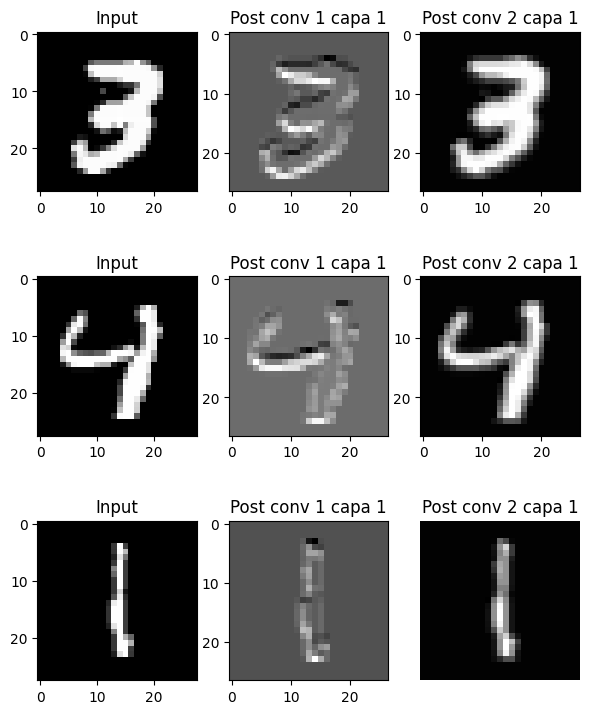

In [43]:
import matplotlib.pyplot as plt
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 3,figsize =(7,9))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(all_mnist_test), size=(1,)).item()
        img, label = all_mnist_test[sample_idx]

        post_conv = model.conv1.forward(img.unsqueeze(0).to(device))
        #print(post_conv[0,0].shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("Input")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post conv 1 capa 1")
        ax[row][2].imshow(post_conv[0,1].cpu(), cmap="gray")
        ax[row][2].set_title("Post conv 2 capa 1")

torch.Size([1, 4, 12, 12])
torch.Size([1, 4, 12, 12])
torch.Size([1, 4, 12, 12])


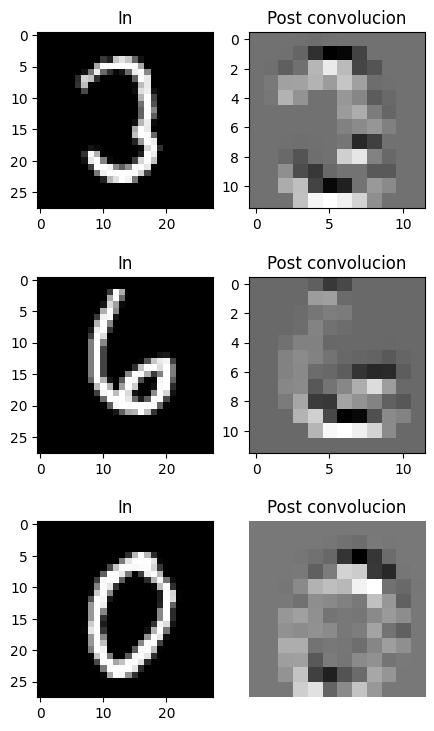

In [49]:
import matplotlib.pyplot as plt
rows =3
fig, ax  = plt.subplots(nrows = rows ,ncols = 2,figsize =(5,9))
pool = nn.MaxPool2d(kernel_size=(2, 2))
with torch.no_grad():
    #figure.add_subplot(rows, cols, i)
    #  ax.title([label])
    for row in range(rows):
        plt.axis("off")
        sample_idx = torch.randint(len(all_mnist_test), size=(1,)).item()
        img, label = all_mnist_test[sample_idx]

        post_conv = pool(model.conv1.forward(img.unsqueeze(0).to(device)))
        post_conv = model.conv2.forward(post_conv) 
        
        print(post_conv.shape)
        ax[row][0].imshow(img.squeeze(), cmap="gray")
        ax[row][0].set_title("In")
        ax[row][1].imshow(post_conv[0,0].cpu(), cmap="gray")
        ax[row][1].set_title("Post convolucion")
